# Content 
- [Import Data](#Import-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Preprocessing](#Data-Preprocessing)
- [Tokenization](#Tokenization)
- [Naive Bayes Classifier](#Naive-Bayes-Classifier)
- [Tuning Parameter by CV](#Tuning-Parameter-by-CV)
- [Model Evaluation](#Model-Evaluation)
- [Final Model](#Final-Model)
- [Prediction](#Prediction)
- [Further Work](#Further-Work)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm

import string
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_ks_statistic

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [2]:
data = pd.read_csv('../../data/Disaster/train.csv', index_col = 0)
data.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
data.shape

(7613, 4)

In [4]:
data.isna().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

# Exploratory Data Analysis

In [5]:
data['keyword'].value_counts()
# maybe just use the levels that have frequency over 30

fatalities               45
armageddon               42
deluge                   42
damage                   41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [6]:
len([keyword for keyword in data['keyword'].unique() if keyword is not np.nan and '%' in keyword])

36

In [7]:
len([keyword for keyword in data['keyword'].unique() if keyword is not np.nan and '%20' in keyword])
# %20 means white space

36

In [8]:
data.loc[~data['keyword'].isna(), 'keyword'] = data.loc[~data['keyword'].isna(), 'keyword'].apply(lambda x: x.replace('%20', ' '))
data['keyword'].value_counts()

fatalities             45
armageddon             42
deluge                 42
sinking                41
damage                 41
                       ..
forest fire            19
epicentre              12
threat                 11
inundation             10
radiation emergency     9
Name: keyword, Length: 221, dtype: int64

In [9]:
data['keyword'].value_counts()[data['keyword'].value_counts()>= 30]

fatalities      45
armageddon      42
deluge          42
sinking         41
damage          41
                ..
bioterrorism    30
catastrophic    30
avalanche       30
survivors       30
mayhem          30
Name: keyword, Length: 200, dtype: int64

In [10]:
keyword_30 = data['keyword'].value_counts()[data['keyword'].value_counts()< 30].index.tolist()
keyword_30
# Filter the frequency less than 30

['bombing',
 'first responders',
 'seismic',
 'annihilation',
 'desolate',
 'obliteration',
 'snowstorm',
 'sirens',
 'rubble',
 'demolished',
 'deluged',
 'volcano',
 'battle',
 'bush fires',
 'war zone',
 'rescue',
 'forest fire',
 'epicentre',
 'threat',
 'inundation',
 'radiation emergency']

In [11]:
print('keyword:', data.dropna(subset = ['keyword']).iloc[1, 0])
print('location:', data.dropna(subset = ['keyword']).iloc[1, 1])
print('text:', data.dropna(subset = ['keyword']).iloc[1, 2])
# keyword and location may not be mentioned in the text

keyword: ablaze
location: Est. September 2012 - Bristol
text: We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw


In [12]:
data['location'].value_counts()
# too much level

USA                       104
New York                   71
United States              50
London                     45
Canada                     29
                         ... 
Sunny South florida         1
Bronx, New York             1
US: 44.414510,8.942499      1
Brasil,SP                   1
We're All Mad Here          1
Name: location, Length: 3341, dtype: int64

In [13]:
print(data.loc[data['target'] == 1, 'text'].sample(10).values)
# hasttag
# @ tag
# \r\n

['Gas leak forces evacuation in east Saint John http://t.co/E1vkc2efsT #NB http://t.co/BeUa507Iug'
 'Japan had a nuke program (albeit unsuccessful) and the casualty estimates for a ground war were in the tens of millions. @MacKinnon08'
 'RT @calestous: Tanzania elephant population declined by 60% in five years census reveals http://t.co/8zy9N6fX9T http://t.co/ITZ9masBvZ'
 'Firefighting consumes Forest Service budget sparks political clash: Forest Service report cites increasing cost of\x89Û_ http://t.co/lSWsitnkuk'
 'Business at the Sponge Docks washed out by rain flooding: http://t.co/5PmikAVyKL'
 'Evacuation order lifted for town of Roosevelt: http://t.co/EDyfo6E2PU http://t.co/M5KxLPKFA1'
 'As of the 6-month mark there were a total of 662 fatalities - 114 more than the first half of last year || http://t.co/reOz7H3Em8'
 'I moved to England five years ago today. What a whirlwind of time it has been! http://t.co/eaSlGeA1B7'
 '#flood #disaster Heavy rain causes flash flooding of street

In [14]:
print(data.loc[data['target'] == 0, 'text'].sample(10).values)

['#Spotlight Take Me To Paradise by Arsonist MC #WNIAGospel http://t.co/1he4UfaWZm @arsonistmusic http://t.co/BNhtxAEZMM'
 'A young heavyweight rapping off of detonate I been a leader not a lemon better get it straight ??'
 '@RaabChar_28 @DrPhil @MorganLawGrp How do you self-inflict a wound to your side and blunt force trauma not consistent with fall dimensions?!'
 '\x89ÛÏStretcher in 5 min // Speaker Deck\x89Û\x9d http://t.co/fBLNiFda1C'
 "We would become the mirrors that reflected each other's most private wounds and desires."
 '#Pandemonium.iso psp http://t.co/HbpNFOAwII'
 "The worst  voice I can ever hear is the 'Nikki your in trouble' voice from my mom"
 'What would you do if you were trapped in a collapsed circus tent with a bunch of clowns? http://t.co/6HKCa1dSna'
 'Some good info to help first responders cope- Individual Resilience: Factsheet for Responders- http://t.co/FcFpijiqt5'
 "If there's a chance will get a gander of the sinking ship that is #TNA too. Can't help but appe

In [15]:
data['target'].value_counts()
# A bit unbalanced

0    4342
1    3271
Name: target, dtype: int64

# Data Preprocessing

In [16]:
data_rescale = data.copy()

In [17]:
data_rescale['location'] = 1 - data['location'].isna()
data_rescale.head()

,keyword,location,text,target
id,,,,
1,NaN,0,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,0,Forest fire near La Ronge Sask. Canada,1
5,NaN,0,All residents asked to 'shelter in place' are ...,1
6,NaN,0,"13,000 people receive #wildfires evacuation or...",1
7,NaN,0,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
data_rescale['location'].value_counts()

1    5080
0    2533
Name: location, dtype: int64

In [19]:
data_rescale['keyword'] = data['keyword'].replace(keyword_30, ['Others'] * len(keyword_30))
data_rescale.head()

,keyword,location,text,target
id,,,,
1,NaN,0,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,0,Forest fire near La Ronge Sask. Canada,1
5,NaN,0,All residents asked to 'shelter in place' are ...,1
6,NaN,0,"13,000 people receive #wildfires evacuation or...",1
7,NaN,0,Just got sent this photo from Ruby #Alaska as ...,1


In [20]:
data_rescale['keyword'] = data_rescale['keyword'].fillna('Not mentioned')
data_rescale.head()

,keyword,location,text,target
id,,,,
1,Not mentioned,0,Our Deeds are the Reason of this #earthquake M...,1
4,Not mentioned,0,Forest fire near La Ronge Sask. Canada,1
5,Not mentioned,0,All residents asked to 'shelter in place' are ...,1
6,Not mentioned,0,"13,000 people receive #wildfires evacuation or...",1
7,Not mentioned,0,Just got sent this photo from Ruby #Alaska as ...,1


In [21]:
data_rescale['keyword'].value_counts()

Others           500
Not mentioned     61
fatalities        45
armageddon        42
deluge            42
                ... 
dead              30
mayhem            30
catastrophic      30
avalanche         30
survivors         30
Name: keyword, Length: 202, dtype: int64

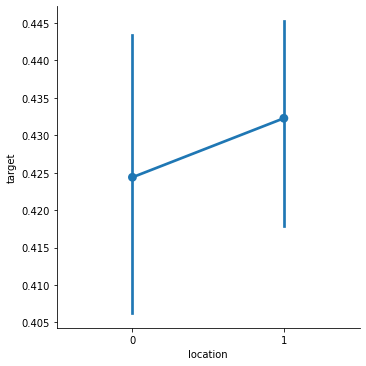

In [22]:
sns.factorplot(data = data_rescale, x = 'location', y = 'target')
plt.show()

In [23]:
chi2_contingency(pd.crosstab(data_rescale['location'], data_rescale['target']), correction=False)
# Independent

(0.42888885897570894,
 0.5125346724399973,
 1,
 array([[1444.6717457, 1088.3282543],
        [2897.3282543, 2182.6717457]]))

In [24]:
chi2_contingency(pd.crosstab(data_rescale['keyword'], data_rescale['target']), correction=False)[1]
# Not independent

0.0

In [25]:
data['length'] = data['text'].apply(len)
data.head()

,keyword,location,text,target,length
id,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


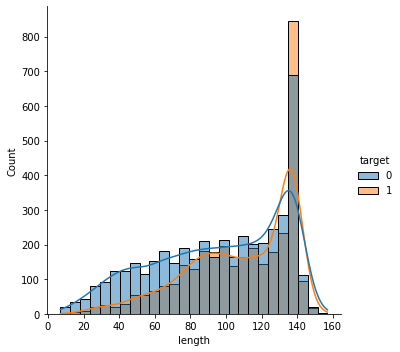

In [26]:
sns.displot(data = data, x = 'length', hue = 'target', kde = True)
plt.show()
# Similar distribution

In [27]:
def text_preprocessing(text):
    text = TweetTokenizer(strip_handles=True, reduce_len=True).tokenize(text)
    text = [t for t in text if t not in string.punctuation]
    text = [t.lower() for t in text if t.lower() not in stopwords.words('english')]
    stemmer = PorterStemmer()
    text = [stemmer.stem(t) for t in text]
    return text

# https://berkeley-stat159-f17.github.io/stat159-f17/lectures/11-strings/11-nltk..html

In [28]:
text_sample = data['text'].sample(1).values[0]

print(text_sample)
text_preprocessing(text_sample)

Washington Post - 4 dead dozens injured in Gaza blast near house leveled in summer war http://t.co/VjXa13n8Ap


['washington',
 'post',
 '4',
 'dead',
 'dozen',
 'injur',
 'gaza',
 'blast',
 'near',
 'hous',
 'level',
 'summer',
 'war',
 'http://t.co/vjxa13n8ap']

In [29]:
data_rescale = data_rescale.drop(columns = 'location')

In [30]:
train, test = train_test_split(data_rescale, test_size = 0.3, random_state = 0)
train.shape, test.shape

((5329, 3), (2284, 3))

# Naive Bayes Classifier

We assume that keyword follows categorical distribution and the word vectors follow multinomial distribution. Therefore, we decide to combine two naive bayes classifiers as the two features are under different distribution.

In [31]:
X = train.drop(columns = 'target')
y = train['target']

In [32]:
X.head()

,keyword,text
id,,
686,attack,@blazerfan not everyone can see ignoranceshe i...
6913,mass murderer,White people I know you worry tirelessly about...
6066,heat wave,Chilli heat wave Doritos never fail!
1441,body bagging,@BroseidonRex @dapurplesharpie I skimmed throu...
6365,hostages,#hot C-130 specially modified to land in a st...


In [33]:
class CategoricalNBTransformer():
    def __init__(self, alpha=1.0, fit_prior=True, class_prior=None):
        self.alpha = alpha
        self.fit_prior = fit_prior
        self.class_prior = class_prior
        
    def fit(self, X, y):
        self.model = CategoricalNB(alpha = self.alpha, fit_prior = self.fit_prior, 
                              class_prior = self.class_prior).fit(X, y)
        return self
    
    def transform(self, X):
        return self.model.predict_proba(X)

In [34]:
class MultinomialNBTransformer():
    def __init__(self, alpha=1.0, fit_prior=True, class_prior=None):
        self.alpha = alpha
        self.fit_prior = fit_prior
        self.class_prior = class_prior
        
    def fit(self, X, y):
        self.model = MultinomialNB(alpha = self.alpha, fit_prior = self.fit_prior, 
                                   class_prior = self.class_prior).fit(X, y)
        return self
    
    def transform(self, X):
        return self.model.predict_proba(X)

In [35]:
class NaiveBayesClassifier():
    def __init__(self):
        pass
    
    def fit(self, X, y):
        self.n_classes = y.nunique()
        self.classes = y.unique()
        return self
    
    def predict(self, X):
        return np.array([self.classes[np.argmax(x)] for x in self.predict_proba(X)])
    
    def predict_proba(self, X):
        product = X[:, :self.n_classes] * X[:, self.n_classes: ]
        return product / product.sum(axis = 1).reshape(-1, 1)

In [36]:
model = Pipeline([('mixed', FeatureUnion([('categorical', Pipeline([('keyword', FunctionTransformer(func = lambda x: x['keyword'].values.reshape(-1, 1), validate = False)),
                                                                    ('ordinal_transformer', OrdinalEncoder()),
                                                                    ('categoricalnb', CategoricalNBTransformer())])),
                                          ('multinomial', Pipeline([('text', FunctionTransformer(func = lambda x: x['text'], validate = False)),
                                                                    ('bow_transformer', CountVectorizer(analyzer = text_preprocessing)),
                                                                    ('multinomialnb', MultinomialNBTransformer())]))])),
                  ('model', NaiveBayesClassifier())])

In [37]:
model.fit(X, y)

Pipeline(memory=None,
         steps=[('mixed',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical',
                                                 Pipeline(memory=None,
                                                          steps=[('keyword',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x000002A5A9747C80>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                         

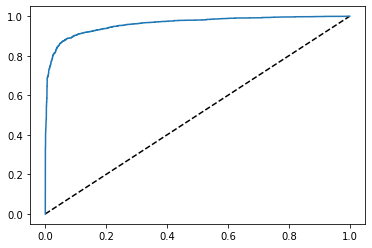

0.9613846770614092


In [38]:
fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

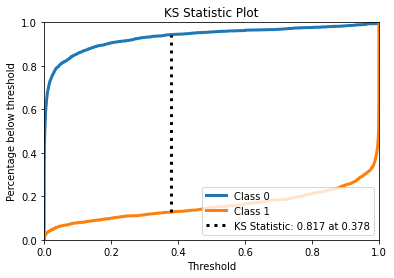

In [39]:
plot_ks_statistic(y, model.predict_proba(X))
plt.show()

In [40]:
accuracy_score(y, [1 if prob >= 0.378 else 0 for prob in model.predict_proba(X)[:, 1]])

0.9127416025520736

In [41]:
confusion_matrix(y, [1 if prob >= 0.378 else 0 for prob in model.predict_proba(X)[:, 1]])

array([[2834,  170],
       [ 295, 2030]], dtype=int64)

In [42]:
print(cross_val_score(model, X, y, scoring = 'roc_auc', cv=5))
# Overfitting

[0.84211425 0.86161261 0.86429271 0.85310532 0.84384964]


# Tuning Parameter by CV

In [43]:
params = {'mixed__multinomial__bow_transformer__min_df': [0, 0.05, 0.1, 0.2, 0.5],
          'mixed__multinomial__bow_transformer__max_features': [1000, 5000, 10000, None],
          'mixed__multinomial__bow_transformer__ngram_range':[(1, 1), (1, 2), (2, 2)]}
grid = GridSearchCV(model, param_grid = params, cv = 5, scoring = 'roc_auc').fit(X, y)

In [44]:
grid.best_score_

0.8541149107135995

In [45]:
grid.best_params_

{'mixed__multinomial__bow_transformer__max_features': 5000,
 'mixed__multinomial__bow_transformer__min_df': 0,
 'mixed__multinomial__bow_transformer__ngram_range': (1, 1)}

# Model Evaluation

In [46]:
model = Pipeline([('mixed', FeatureUnion([('categorical', Pipeline([('keyword', FunctionTransformer(func = lambda x: x['keyword'].values.reshape(-1, 1), validate = False)),
                                                                    ('ordinal_transformer', OrdinalEncoder()),
                                                                    ('categoricalnb', CategoricalNBTransformer())])),
                                          ('multinomial', Pipeline([('text', FunctionTransformer(func = lambda x: x['text'], validate = False)),
                                                                    ('bow_transformer', CountVectorizer(max_features = 5000,
                                                                                                        analyzer = text_preprocessing)),
                                                                    ('multinomialnb', MultinomialNBTransformer())]))])),
                  ('model', NaiveBayesClassifier())])

In [47]:
model.fit(X, y)

Pipeline(memory=None,
         steps=[('mixed',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical',
                                                 Pipeline(memory=None,
                                                          steps=[('keyword',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x000002A5A98B72F0>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                         

In [48]:
test_X = test.drop(columns = 'target')
test_y = test['target']

## Train

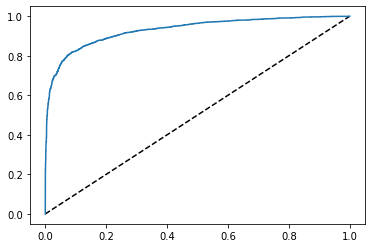

0.9307025757771001


In [49]:
fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

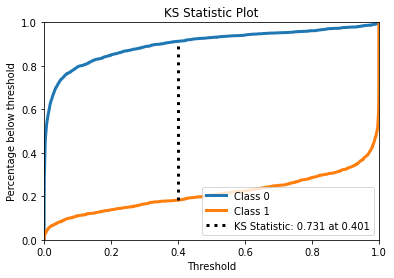

In [50]:
plot_ks_statistic(y, model.predict_proba(X))
plt.show()

In [51]:
accuracy_score(y, [1 if prob >= 0.401 else 0 for prob in model.predict_proba(X)[:, 1]])

0.8714580596734847

In [52]:
confusion_matrix(y, [1 if prob >= 0.401 else 0 for prob in model.predict_proba(X)[:, 1]])

array([[2742,  262],
       [ 423, 1902]], dtype=int64)

## Test

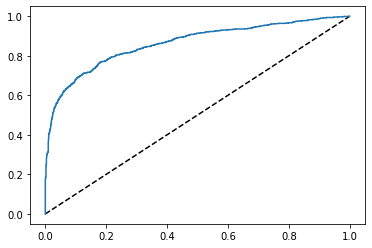

0.862639719754643


In [53]:
fpr, tpr, _ = roc_curve(test_y, model.predict_proba(test_X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

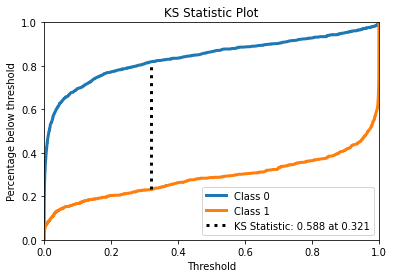

In [54]:
plot_ks_statistic(test_y, model.predict_proba(test_X))
plt.show()

In [55]:
accuracy_score(test_y, [1 if prob >= 0.401 else 0 for prob in model.predict_proba(test_X)[:, 1]])

0.7950963222416813

In [56]:
confusion_matrix(test_y, [1 if prob >= 0.401 else 0 for prob in model.predict_proba(test_X)[:, 1]])

array([[1118,  220],
       [ 248,  698]], dtype=int64)

# Final Model

In [57]:
def keyword_preprocessing(df):
    df.loc[~df['keyword'].isna(), 'keyword'] = df.loc[~df['keyword'].isna(), 'keyword'].apply(lambda x: x.replace('%20', ' '))
    df['keyword'] = df['keyword'].replace(keyword_30, ['Others'] * len(keyword_30))
    df['keyword'] = df['keyword'].fillna('Not mentioned')
    return df['keyword'].values.reshape(-1, 1)

In [58]:
model = Pipeline([('mixed', FeatureUnion([('categorical', Pipeline([('keyword', FunctionTransformer(func = keyword_preprocessing, validate = False)),
                                                                    ('ordinal_transformer', OrdinalEncoder()),
                                                                    ('categoricalnb', CategoricalNBTransformer())])),
                                          ('multinomial', Pipeline([('text', FunctionTransformer(func = lambda x: x['text'], validate = False)),
                                                                    ('bow_transformer', CountVectorizer(analyzer = text_preprocessing,
                                                                                                        max_features = 5000)),
                                                                    ('multinomialnb', MultinomialNBTransformer())]))])),
                  ('model', NaiveBayesClassifier())])

In [59]:
X = data.drop(columns = 'target')
y = data['target']

In [60]:
model.fit(X, y)

Pipeline(memory=None,
         steps=[('mixed',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical',
                                                 Pipeline(memory=None,
                                                          steps=[('keyword',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function keyword_preprocessing at 0x000002A5A9A58C80>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                            

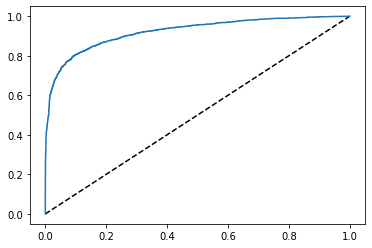

0.9217180600114824


In [61]:
fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

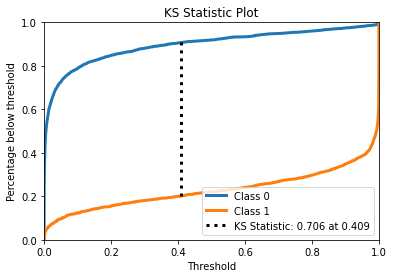

In [62]:
plot_ks_statistic(y, model.predict_proba(X))
plt.show()

In [63]:
accuracy_score(y, [1 if prob >= 0.409 else 0 for prob in model.predict_proba(X)[:, 1]])

0.8606331275449889

In [64]:
confusion_matrix(y, [1 if prob >= 0.409 else 0 for prob in model.predict_proba(X)[:, 1]])

array([[3939,  403],
       [ 658, 2613]], dtype=int64)

# Prediction

In [65]:
predict = pd.read_csv('../../data/Disaster/test.csv', index_col = 0)
predict.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [66]:
sample = pd.DataFrame(index = predict.index)
sample['target'] = [1 if prob >= 0.409 else 0 for prob in model.predict_proba(predict)[:, 1]]
sample.head()

,target
id,
0,1
2,1
3,1
9,1
11,1


In [67]:
sample.to_csv('../../data/Disaster/submission.csv')

# Score in Kaggle

0.78976

# Further Work

1. The tokenization takes the most important part in the modelling. We can try different tokenization method, like tf-idf and word2vec.
3. We converted the location into a dummy variable indicating whether the tweet provided location. But based on Pearson's goodness of fit test on contigency table, it is not significantly dependent to the target. Next time, we can try to select the top n levels from location and group the remaining levels into 'Others'.